<h1 style="text-align: center">
Deep Learning HW3 </br>
Question 1
</h1>


### Full Name: Amirabbas Afzali

### Student ID: 400100662

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 32.9 MB/s eta 0:00:00


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold

import pickle
import rdkit
import re
from rdkit import Chem
from IPython.display import display
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
df = pd.read_csv('/content/drive/My Drive/DEEP/HW4/Q1 Materials/BBBP.csv')
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [48]:
df['smiles length'] = df['smiles'].apply(len)

In [7]:
df.head()

,num,name,p_np,smiles,smiles length
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,32
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,40
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,50
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,32
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,66


## analysis the length of smiles for two class.

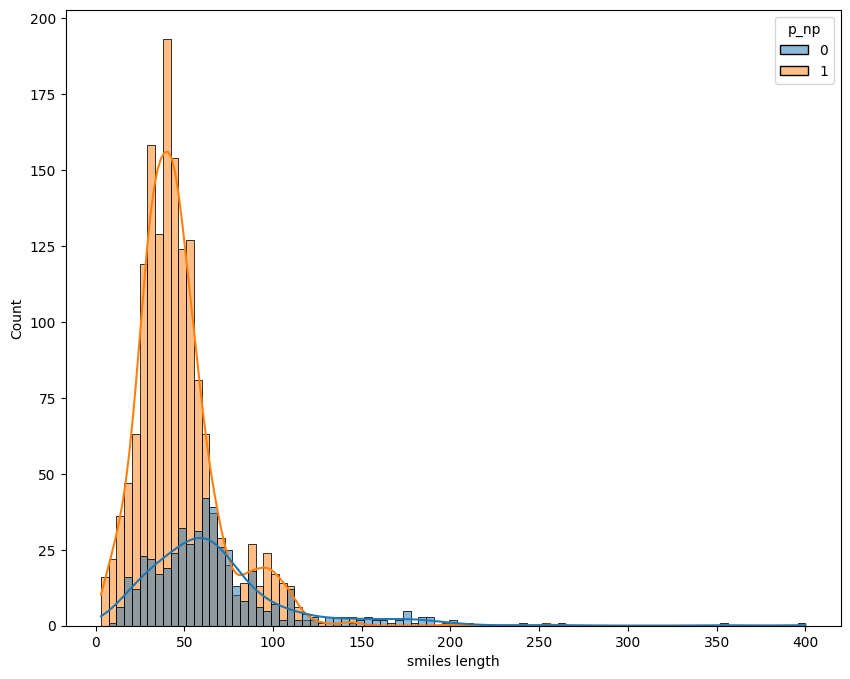

In [126]:
plt.figure(figsize=(10,8))
sns.histplot(data = df, x = 'smiles length',hue= 'p_np',kde=True);

### Draw some sample of dataset

[Cl].CC(C)NCC(O)COc1cccc2ccccc12 



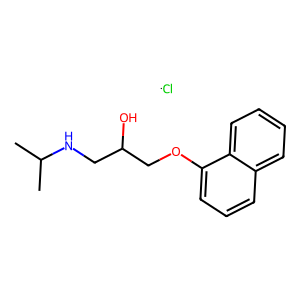

In [127]:
print(df['smiles'][0],'\n')

taxol = Chem.MolFromSmiles(df['smiles'][0])
Draw.MolToImage(taxol, size=(300, 300))

OCC(C)(O)c1onc(c2ncn3c2CN(C)C(c4c3cccc4Cl)=O)n1 



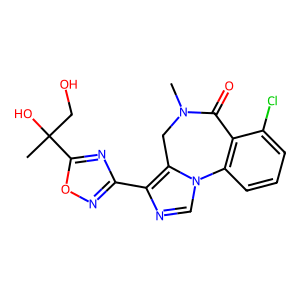

In [128]:
print(df['smiles'][10],'\n')

taxol = Chem.MolFromSmiles(df['smiles'][10])

Draw.MolToImage(taxol, size=(300, 300))

CCCC(C)C1(CC)C(=O)NC(=O)NC1=O 



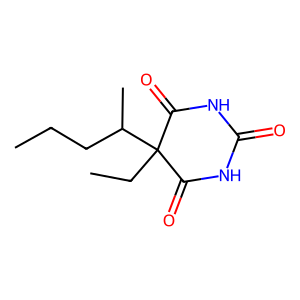

In [129]:
print(df['smiles'][30],'\n')

taxol = Chem.MolFromSmiles(df['smiles'][30])
Draw.MolToImage(taxol, size=(300, 300))

## analysis diversity of tokens



In [49]:
import numpy as np
import re  # Regular expression module for pattern matching


# Tokenize the SMILES string based on the defined regex pattern
def tokenizer(smiles_string):
  """
  Tokenize the SMILES string using the predefined regex pattern
  :param smiles_string: Input SMILES string
  :return: List of tokens extracted from the input string
  """
  # Define the SMILES regex pattern
  SMI_REGEX_PATTERN = r"""(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"""
  regex = re.compile(SMI_REGEX_PATTERN)

  tokens = []
  for token in regex.findall(smiles_string):
    tokens.append(token)
  return tokens

# Build vocabulary from the given dataset
def build_vocab(smiles):
  """
  Build vocabulary from the input dataset
  :param data: Input dataset containing SMILES strings
  :return: Tuple containing the vocabulary and its inverse dictionary
  """
  if not isinstance(smiles, list):
    smiles = list(smiles)

  vocab_ = set()

  # save all tokens in dataset
  for ex in smiles:
    for letter in tokenizer(ex):
      vocab_.add(letter)

  vocab = {}
  vocab['<PAD>'] = 0
  vocab['<UNK>'] = 1
  for i, letter in enumerate(vocab_):
    vocab[letter] = i + 2

  return vocab

# Convert SMILES strings to one-hot encoded data
def make_one_hot(data, vocab, max_len):
  """
  Convert the input SMILES strings to one-hot encoded data
  :param data: Input SMILES strings
  :param vocab: Vocabulary for encoding
  :param max_len: Maximum length for padding
  :return: One-hot encoded data matrix
  """
  # tokenizer = Tokenizer(char_level=True)
  # tokenizer.fit_on_texts(data)
  # vocab = tokenizer.word_index

  tokens = vocab.keys()
  one_hot = np.zeros((len(data), max_len, len(vocab)))

  for i, smiles in enumerate(data):
    smiles = tokenizer(smiles)
    smiles = smiles[:max_len] + ['<PAD>'] * (max_len - len(smiles))
    for j, letter in enumerate(smiles):
      if letter in tokens:
        one_hot[i, j, vocab[letter]] = 1
      else: # if token not exist in vacab
        one_hot[i, j, vocab['<UNK>']] = 1

  return one_hot

In [50]:
vocab = build_vocab(df['smiles'])
print("Vocab",vocab)
print("Vocab Size: ",len(vocab))

data_one_hot = make_one_hot(df['smiles'],vocab,75)
print("data shape: ",data_one_hot.shape)

Vocab {'<PAD>': 0, '<UNK>': 1, '[n+]': 2, 'O': 3, '[CH2-]': 4, '[NH-]': 5, '8': 6, '[OH-]': 7, '[NH3+]': 8, '[S@]': 9, '(': 10, '[N]': 11, 'B': 12, '[S+]': 13, '[Na]': 14, '[O+]': 15, '4': 16, 'S': 17, '[NH+]': 18, 'Cl': 19, '[H+]': 20, '[Cl]': 21, 'C': 22, '[o+]': 23, '[NH2+]': 24, '[NH2]': 25, '[C@@H]': 26, '[Na+]': 27, '[N@]': 28, '3': 29, '2': 30, '/': 31, 'N': 32, '[S]': 33, 'o': 34, '[C@H]': 35, '[P]': 36, 'Br': 37, '[H]': 38, '[N+]': 39, '%14': 40, '\\': 41, '9': 42, '[Br-]': 43, '5': 44, '[C@@]': 45, 'I': 46, 'F': 47, '[C@]': 48, '7': 49, '[nH]': 50, '=': 51, '%10': 52, '[Ca++]': 53, '%11': 54, '[C-]': 55, '[O-]': 56, 'c': 57, '[N-]': 58, '[CH-]': 59, '[Cl-]': 60, '[NH]': 61, '[nH+]': 62, 'n': 63, ')': 64, 's': 65, '#': 66, '[N@@]': 67, '.': 68, '1': 69, '6': 70, '%13': 71, '%12': 72}
Vocab Size:  73
data shape:  (2050, 75, 73)


In [51]:
def count_tokens(data, vocab):
  tokens = vocab.keys()
  one_hot = np.zeros(len(vocab),dtype=np.int64)

  for i, smiles in enumerate(data):
    smiles = tokenizer(smiles)
    # smiles = smiles[:max_len] + ['<PAD>'] * (max_len - len(smiles))
    for j, letter in enumerate(smiles):
      if letter in tokens:
        one_hot[vocab[letter]] += 1
      else: # if token not exist in vacab
        one_hot[vocab['<UNK>']] += 1

  return one_hot

In [11]:
# number of differnt tokens in the all data
count_all = count_tokens(df['smiles'],vocab)
count_all

array([    0,     0,     2,  6142,     1,     1,    28,     1,     1,
           1, 10491,    77,     1,     1,     2,     1,  1434,   405,
           2,   570,    40,     5, 26859,     1,     2,     1,   893,
          19,    14,  2548,  3362,   184,  3724,   103,    48,  1354,
          11,    45,     4,    49,     4,   203,    16,     6,   454,
         350,     6,   509,   323,    56,    40,  8034,     8,     1,
           4,     2,    64,  6937,     4,     1,    43,    50,     1,
         472, 10491,    72,    53,     8,   163,  4100,   124,     4,
           4])

In [12]:
# number of differnt tokens in the class 0
count_all0 = count_tokens(df[df['p_np']==0]['smiles'],vocab)
count_all0

array([   0,    0,    0, 2620,    0,    0,   18,    0,    1,    1, 3413,
          0,    0,    0,    2,    0,  372,  171,    1,   97,    7,    2,
       5390,    0,    0,    0,  477,   12,   12,  654,  846,  116, 1102,
         42,   26,  736,    2,    5,    0,   19,    4,  105,   10,    5,
        132,   64,    5,   43,  123,   32,   21, 1530,    6,    0,    4,
          2,   24, 3238,    1,    0,    8,    5,    0,  266, 3413,   45,
         16,    4,   57, 1018,   50,    4,    4])

In [13]:
# number of differnt tokens in the class 1
count_all1 = count_tokens(df[df['p_np']==1]['smiles'],vocab)
count_all1

array([    0,     0,     2,  3522,     1,     1,    10,     1,     0,
           0,  7078,    77,     1,     1,     0,     1,  1062,   234,
           1,   473,    33,     3, 21469,     1,     2,     1,   416,
           7,     2,  1894,  2516,    68,  2622,    61,    22,   618,
           9,    40,     4,    30,     0,    98,     6,     1,   322,
         286,     1,   466,   200,    24,    19,  6504,     2,     1,
           0,     0,    40,  3699,     3,     1,    35,    45,     1,
         206,  7078,    27,    37,     4,   106,  3082,    74,     0,
           0])

### Bar plot

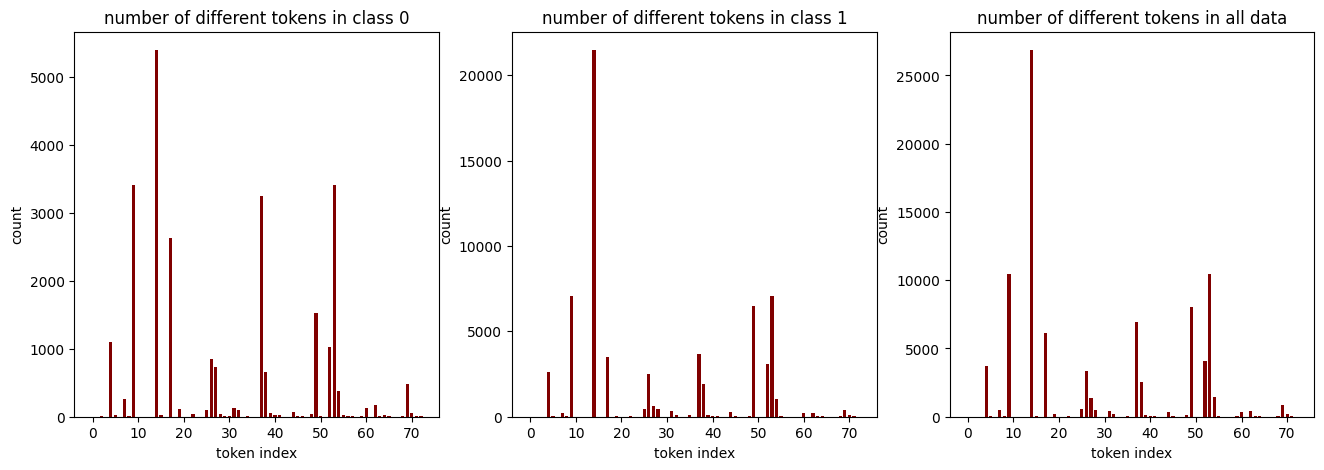

In [136]:
# Create subplots
plt.figure(figsize=(16, 5))

# First subplot
plt.subplot(1, 3, 1)  # (rows, columns, plot number)
plt.bar(range(len(list(vocab.keys()))), count_all0, color ='maroon',
        width = 0.7)

plt.xlabel("token index")
plt.ylabel("count")
plt.title("number of different tokens in class 0")

# Second subplot
plt.subplot(1, 3, 2)
plt.bar(range(len(list(vocab.keys()))), count_all1, color ='maroon',
        width = 0.7)
plt.xlabel("token index")
plt.ylabel("count")
plt.title("number of different tokens in class 1")


# Second subplot
plt.subplot(1, 3, 3)
plt.bar(range(len(list(vocab.keys()))), count_all, color ='maroon',
        width = 0.7)
plt.xlabel("token index")
plt.ylabel("count")
plt.title("number of different tokens in all data")

# Display the plots
plt.show()

### Create Dataset and Dataloader

In [52]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [53]:
from torch.utils.data import random_split

X_data = data_one_hot.reshape(data_one_hot.shape[0],-1)

my_dataset = MyDataset(X_data,df['p_np'])
one_hot_dataset = MyDataset(data_one_hot,df['p_np'])

dataset_size = df.shape[0]
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # Remaining 20% for testing

train_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])

train_dataset_lstm, test_dataset_lstm = random_split(one_hot_dataset, [train_size, test_size])

In [54]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_dataloader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
test_dataloader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size, shuffle=True)

In [55]:
for (data, targets) in tqdm(train_dataloader):
  print('\n',data.shape,targets.shape)
  break

  0%|          | 0/52 [00:00<?, ?it/s]


 torch.Size([32, 5475]) torch.Size([32])


#Part b)

# Define FC network


In [23]:
class FCNet(nn.Module):
  def __init__(self, input_size):
      super(FCNet, self).__init__()

      # self.fc = nn.Sequential(
      #     nn.Linear(input_size, 8192),
      #     nn.ReLU(),
      #     nn.Linear(8192, 2048),
      #     nn.ReLU(),
      #     nn.Linear(2048, 512),
      #     nn.ReLU(),
      #     nn.Linear(512, 1)
      #             )
      self.fc = nn.Sequential(
          nn.Linear(input_size, 1),)

  def forward(self, x):
      x = self.fc(x)
      # x = nn.BatchNorm1d(x)
      return torch.sigmoid(x)

In [142]:
fc_model = FCNet(X_data.shape[-1]).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
num_epochs = 20
loss_list = []
accuracy_list = []

for _ in range(num_epochs):
    fc_model.train()

    epoch_loss = 0.0
    accuracies = []

    for (data, targets) in tqdm(train_dataloader):
        data = data.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = fc_model(data).squeeze(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(outputs.shape)
        predicted = torch.zeros(outputs.shape[0]).to(device)
        indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        correct = (predicted == targets).sum().item()

        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

    print(f'Loss: {epoch_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
    loss_list.append(epoch_loss)
    accuracy_list.append(100*accuracy)



100%|██████████| 52/52 [00:00<00:00, 354.31it/s]


Loss: 0.5079, Accuracy: 77.28%


100%|██████████| 52/52 [00:00<00:00, 357.40it/s]


Loss: 0.4206, Accuracy: 79.69%


100%|██████████| 52/52 [00:00<00:00, 350.65it/s]


Loss: 0.3721, Accuracy: 82.93%


100%|██████████| 52/52 [00:00<00:00, 345.70it/s]


Loss: 0.3366, Accuracy: 85.58%


100%|██████████| 52/52 [00:00<00:00, 351.97it/s]


Loss: 0.3115, Accuracy: 87.08%


100%|██████████| 52/52 [00:00<00:00, 353.31it/s]


Loss: 0.2945, Accuracy: 87.68%


100%|██████████| 52/52 [00:00<00:00, 334.46it/s]


Loss: 0.2779, Accuracy: 89.18%


100%|██████████| 52/52 [00:00<00:00, 339.68it/s]


Loss: 0.2675, Accuracy: 90.02%


100%|██████████| 52/52 [00:00<00:00, 344.66it/s]


Loss: 0.2545, Accuracy: 90.26%


100%|██████████| 52/52 [00:00<00:00, 334.25it/s]


Loss: 0.2415, Accuracy: 90.62%


100%|██████████| 52/52 [00:00<00:00, 349.05it/s]


Loss: 0.2372, Accuracy: 90.69%


100%|██████████| 52/52 [00:00<00:00, 359.37it/s]


Loss: 0.2270, Accuracy: 91.71%


100%|██████████| 52/52 [00:00<00:00, 349.24it/s]


Loss: 0.2203, Accuracy: 91.71%


100%|██████████| 52/52 [00:00<00:00, 327.06it/s]


Loss: 0.2102, Accuracy: 92.79%


100%|██████████| 52/52 [00:00<00:00, 353.92it/s]


Loss: 0.2060, Accuracy: 92.73%


100%|██████████| 52/52 [00:00<00:00, 350.60it/s]


Loss: 0.1978, Accuracy: 93.03%


100%|██████████| 52/52 [00:00<00:00, 341.00it/s]


Loss: 0.1923, Accuracy: 93.39%


100%|██████████| 52/52 [00:00<00:00, 347.54it/s]


Loss: 0.1891, Accuracy: 93.75%


100%|██████████| 52/52 [00:00<00:00, 354.20it/s]


Loss: 0.1830, Accuracy: 93.99%


100%|██████████| 52/52 [00:00<00:00, 337.26it/s]

Loss: 0.1816, Accuracy: 93.81%


In [ ]:
with torch.no_grad():
    train_accuracy = 0
    for (data, targets) in tqdm(train_dataloader):
        data = data.to(device).float()
        targets = targets.to(device).float()
        train_outputs = fc_model(data)

        predicted = torch.zeros(train_outputs.shape[0]).to(device)
        indices = (train_outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        train_accuracy += (predicted == targets).sum().item() / len(targets)
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)


print('\n train accuracy: ',(train_accuracy/len(train_dataloader))*100)

100%|██████████| 52/52 [00:00<00:00, 523.54it/s]


 train accuracy:  93.50961538461539


In [ ]:
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_dataloader):
        data = data.to(device).float()
        targets = targets.to(device).float()
        test_outputs = fc_model(data)

        predicted = torch.zeros(test_outputs.shape[0]).to(device)
        indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        test_accuracy += (predicted == targets).sum().item() / len(targets)
        accuracies.append(correct / targets.size(0))

print('\n test accuracy: ',(test_accuracy/len(test_dataloader))*100)

100%|██████████| 13/13 [00:00<00:00, 442.57it/s]


 test accuracy:  85.72485207100591


In [152]:
def plot_results(loss_list,accuracy_list):
  # Create subplots
  plt.figure(figsize=(10, 5))

  # First subplot
  plt.subplot(1, 2, 1)  # (rows, columns, plot number)
  plt.plot(loss_list)
  plt.title('Training loss')

  # Second subplot
  plt.subplot(1, 2, 2)
  plt.plot(accuracy_list)
  plt.title('Training accuracy')

  # Display the plots
  plt.show()


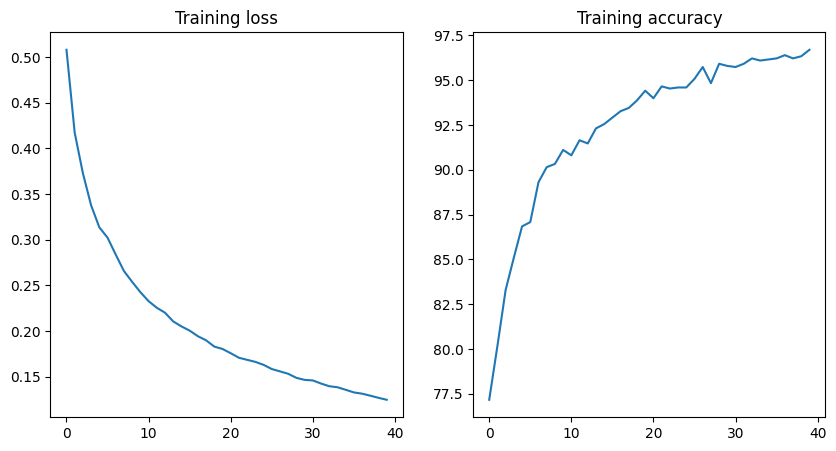

In [ ]:
plot_results(loss_list,accuracy_list)

Save the model

In [ ]:
torch.save(fc_model.state_dict(), '/content/drive/My Drive/DEEP/HW4/fc_model.pth')

## Kfold Validation

In [24]:
from sklearn.model_selection import KFold

def Kfold_Validation(model_class,custom_dataset,is_lstm=False,
                     input_size=None, hidden_size=None, num_layers=None,epochs=None):

  # Define the number of folds
  k = 5
  kf = KFold(n_splits=k, shuffle=True)

  all_acc_train = []
  all_acc_test = []

  # Split the dataset into k folds
  fold_datasets = []
  for train_index, val_index in kf.split(custom_dataset):
      train_subset = Subset(custom_dataset, train_index)
      val_subset = Subset(custom_dataset, val_index)
      fold_datasets.append((train_subset, val_subset))

  # Now you have k (train, val) pairs in fold_datasets, and you can train/validate your model with each pair
  for i, (train_subset, val_subset) in enumerate(fold_datasets):
      # Create data loaders for the current fold
      train_dataloader = DataLoader(train_subset, batch_size=32, shuffle=True)
      test_dataloader = DataLoader(val_subset, batch_size=32, shuffle=True)

      if is_lstm:
        model = model_class(input_size, hidden_size, num_layers).to(device)
      else:
        model = model_class(X_data.shape[-1]).to(device)
      criterion = nn.BCELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
      num_epochs = 20

      best_accuracy = 0.0
      best_epoch = 0
      best_model_state = None

      # training loop
      for _ in range(num_epochs):
          model.train()

          epoch_loss = 0.0
          accuracies = []
          acc = 0

          for (data, targets) in train_dataloader:
              data = data.to(device).float()
              targets = targets.to(device).float()

              optimizer.zero_grad()
              outputs = model(data).squeeze(-1)
              loss = criterion(outputs, targets)

              loss.backward()
              optimizer.step()

              epoch_loss += loss.item()
              # print(outputs.shape)
              predicted = torch.zeros(outputs.shape[0]).to(device)
              indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
              predicted[indices] = 1

              acc += (predicted == targets).sum().item() / len(targets)

          if is_lstm:
            if acc > best_accuracy:
                best_accuracy = accuracy
                bestmodel = model.state_dict()


      if is_lstm:
        model.load_state_dict(bestmodel)

      # store model result
      model.eval()
      with torch.no_grad():
        train_accuracy = 0
        for (data, targets) in train_dataloader:
          data = data.to(device).float()
          targets = targets.to(device).float()
          train_outputs = model(data)

          predicted = torch.zeros(train_outputs.shape[0]).to(device)
          indices = (train_outputs > 0.5).nonzero(as_tuple=False).squeeze()
          predicted[indices] = 1
          train_accuracy += (predicted == targets).sum().item() / len(targets)

      model.eval()
      with torch.no_grad():
        test_accuracy = 0
        for (data, targets) in test_dataloader:
            data = data.to(device).float()
            targets = targets.to(device).float()
            test_outputs = model(data)

            predicted = torch.zeros(test_outputs.shape[0]).to(device)
            indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
            predicted[indices] = 1
            test_accuracy += (predicted == targets).sum().item() / len(targets)


      res_test = (test_accuracy/len(test_dataloader))*100
      res_train = (train_accuracy/len(train_dataloader))*100

      all_acc_train.append(res_train)
      all_acc_test.append(res_test)

  return np.mean(all_acc_train),np.std(all_acc_train),\
          np.mean(all_acc_test),np.std(all_acc_test)



In [ ]:
fc_dataset = MyDataset(X_data,df['p_np'])
one_hot_dataset = MyDataset(data_one_hot,df['p_np'])

In [ ]:
acc_train_mean,acc_train_std,acc_test_mean,acc_test_std = Kfold_Validation(FCNet,fc_dataset)

In [ ]:
print(f'Train accuracy: {acc_train_mean} ± {acc_train_std}')
print(f'Test accuracy: {acc_test_mean} ± {acc_test_std}')

Train accuracy: 93.66586538461539 ± 0.7045361004688822
Test accuracy: 87.94748520710058 ± 1.6464121565972247


#Part C,D,E

In [71]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_size , 1)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = out[:, -1, :].reshape(out.shape[0], -1)

        # Decode the hidden state of the last time step
        out = self.fc(out)
        return torch.sigmoid(out)

In [145]:
input_size = 73
hidden_size = 64
num_layers = 4

LSTM_model = RNN_LSTM(input_size, hidden_size, num_layers).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)
num_epochs = 70
accuracy_list2 = []
loss_list2 = []

for epoch in range(num_epochs):
    LSTM_model.train()

    epoch_loss = 0.0
    accuracies = []

    for (data, targets) in train_dataloader_lstm:
        data = data.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = LSTM_model(data).squeeze(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(outputs.shape)
        predicted = torch.zeros(outputs.shape[0]).to(device)
        indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        correct = (predicted == targets).sum().item()
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
    loss_list2.append(epoch_loss)
    accuracy_list2.append(100*accuracy)



Epoch: 1, Loss: 0.5762, Accuracy: 76.74%
Epoch: 2, Loss: 0.5424, Accuracy: 76.92%
Epoch: 3, Loss: 0.5382, Accuracy: 76.56%
Epoch: 4, Loss: 0.5316, Accuracy: 77.46%
Epoch: 5, Loss: 0.5296, Accuracy: 77.94%
Epoch: 6, Loss: 0.5259, Accuracy: 78.06%
Epoch: 7, Loss: 0.5233, Accuracy: 78.31%
Epoch: 8, Loss: 0.5159, Accuracy: 78.85%
Epoch: 9, Loss: 0.5224, Accuracy: 78.37%
Epoch: 10, Loss: 0.5147, Accuracy: 78.91%
Epoch: 11, Loss: 0.5183, Accuracy: 78.55%
Epoch: 12, Loss: 0.5099, Accuracy: 78.91%
Epoch: 13, Loss: 0.5139, Accuracy: 77.34%
Epoch: 14, Loss: 0.5116, Accuracy: 78.43%
Epoch: 15, Loss: 0.4696, Accuracy: 79.15%
Epoch: 16, Loss: 0.4525, Accuracy: 76.02%
Epoch: 17, Loss: 0.4243, Accuracy: 76.92%
Epoch: 18, Loss: 0.4132, Accuracy: 76.74%
Epoch: 19, Loss: 0.4136, Accuracy: 76.92%
Epoch: 20, Loss: 0.4067, Accuracy: 76.92%
Epoch: 21, Loss: 0.4289, Accuracy: 76.20%
Epoch: 22, Loss: 0.3894, Accuracy: 83.47%
Epoch: 23, Loss: 0.3775, Accuracy: 82.87%
Epoch: 24, Loss: 0.3868, Accuracy: 81.97%
E

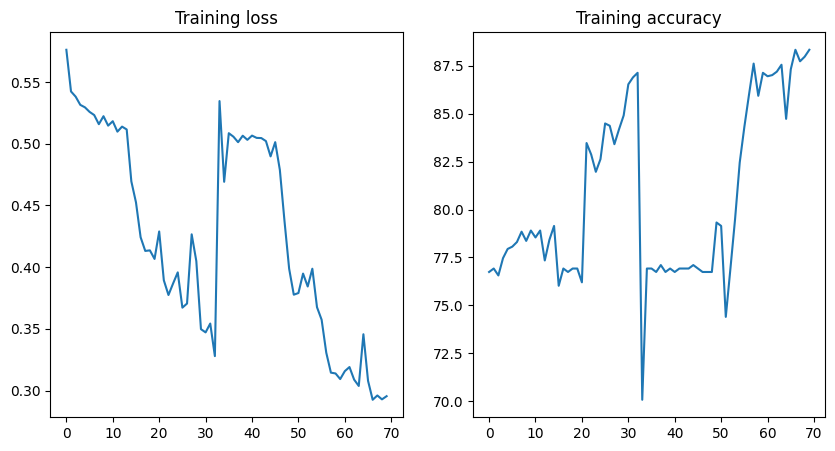

In [ ]:
plot_results(loss_list2,accuracy_list2)

In [ ]:
with torch.no_grad():
    train_accuracy = 0
    for (data, targets) in tqdm(train_dataloader_lstm):
        data = data.to(device).float()
        targets = targets.to(device).float()
        train_outputs = LSTM_model(data)

        predicted = torch.zeros(train_outputs.shape[0]).to(device)
        indices = (train_outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        train_accuracy += (predicted == targets).sum().item() / len(targets)
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)


print('\n train accuracy: ',(train_accuracy/len(train_dataloader))*100)

100%|██████████| 52/52 [00:00<00:00, 261.40it/s]


 train accuracy:  87.98076923076923


In [ ]:
with torch.no_grad():
    test_accuracy = 0
    for (data, targets) in tqdm(test_dataloader_lstm):
        data = data.to(device).float()
        targets = targets.to(device).float()
        test_outputs = LSTM_model(data)

        predicted = torch.zeros(test_outputs.shape[0]).to(device)
        indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        test_accuracy += (predicted == targets).sum().item() / len(targets)
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(test_dataloader)
    accuracy = np.mean(accuracies)


print('\n test accuracy: ',(test_accuracy/len(test_dataloader))*100)

100%|██████████| 13/13 [00:00<00:00, 246.89it/s]


 test accuracy:  84.44896449704143


Save the model

In [ ]:
torch.save(LSTM_model.state_dict(), '/content/drive/My Drive/DEEP/HW4/lstm_model.pth')

## Kfold Validation

In [ ]:
input_size = 73
hidden_size = 64
num_layers = 4

acc_train_mean,acc_train_std,acc_test_mean,acc_test_std = Kfold_Validation(RNN_LSTM,
                     one_hot_dataset,True,input_size, hidden_size, num_layers,epochs=70)


In [ ]:
print(f'Train accuracy: {acc_train_mean} ± {acc_train_std}')
print(f'Test accuracy: {acc_test_mean} ± {acc_test_std}')

Train accuracy: 84.11057692307693 ± 4.0573761497320175
Test accuracy: 83.22855029585799 ± 2.6038497087786525


---
# Bidirectional RNN

In [79]:
class BiRNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiRNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # Note the modification in the linear layer input size

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Note the modification in the initial hidden state size
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Note the modification in the initial cell state size

        # Forward propagate LSTM
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size * 2) due to concatenation of forward and backward hidden states

        # Concatenate the final states of both directions before passing to the linear layer
        out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=1)  # Concatenating hidden states of forward and backward directions

        # Decode the concatenated hidden states of the last time step
        out = self.fc(out)
        return torch.sigmoid(out)


In [148]:

input_size = 73
hidden_size = 64
num_layers = 4

BILSTM_model = BiRNN_LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(BILSTM_model.parameters(), lr=0.001)
num_epochs = 70

loss_list3 = []
accuracy_list3 = []

for epoch in range(num_epochs):
    BILSTM_model.train()

    epoch_loss = 0.0
    accuracies = []

    for (data, targets) in train_dataloader_lstm:
        data = data.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = BILSTM_model(data).squeeze(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(outputs.shape)
        predicted = torch.zeros(outputs.shape[0]).to(device)
        indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        correct = (predicted == targets).sum().item()
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
    loss_list3.append(epoch_loss)
    accuracy_list3.append(100*accuracy)



Epoch: 1, Loss: 0.5654, Accuracy: 74.76%
Epoch: 2, Loss: 0.5102, Accuracy: 78.12%
Epoch: 3, Loss: 0.3819, Accuracy: 82.15%
Epoch: 4, Loss: 0.3363, Accuracy: 84.74%
Epoch: 5, Loss: 0.3155, Accuracy: 85.40%
Epoch: 6, Loss: 0.3117, Accuracy: 85.34%
Epoch: 7, Loss: 0.2765, Accuracy: 87.32%
Epoch: 8, Loss: 0.2612, Accuracy: 87.74%
Epoch: 9, Loss: 0.2474, Accuracy: 88.16%
Epoch: 10, Loss: 0.2467, Accuracy: 89.18%
Epoch: 11, Loss: 0.2313, Accuracy: 89.96%
Epoch: 12, Loss: 0.2421, Accuracy: 89.12%
Epoch: 13, Loss: 0.2297, Accuracy: 89.96%
Epoch: 14, Loss: 0.2169, Accuracy: 90.56%
Epoch: 15, Loss: 0.2256, Accuracy: 89.96%
Epoch: 16, Loss: 0.2337, Accuracy: 89.66%
Epoch: 17, Loss: 0.2430, Accuracy: 88.94%
Epoch: 18, Loss: 0.2231, Accuracy: 89.66%
Epoch: 19, Loss: 0.2313, Accuracy: 89.54%
Epoch: 20, Loss: 0.2272, Accuracy: 89.66%
Epoch: 21, Loss: 0.2477, Accuracy: 88.16%
Epoch: 22, Loss: 0.2249, Accuracy: 89.96%
Epoch: 23, Loss: 0.2180, Accuracy: 90.69%
Epoch: 24, Loss: 0.2011, Accuracy: 91.29%
E

In [150]:
with torch.no_grad():
    train_accuracy = 0
    BILSTM_model.eval()
    for (data, targets) in tqdm(train_dataloader_lstm):
        data = data.to(device).float()
        targets = targets.to(device).float()
        train_outputs = BILSTM_model(data)

        predicted = torch.zeros(train_outputs.shape[0]).to(device)
        indices = (train_outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        train_accuracy += (predicted == targets).sum().item() / len(targets)
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

print('\n train accuracy: ',(train_accuracy/len(train_dataloader))*100)

100%|██████████| 52/52 [00:00<00:00, 165.45it/s]


 train accuracy:  97.17548076923077


In [ ]:
with torch.no_grad():
    test_accuracy = 0
    BILSTM_model.eval()
    for (data, targets) in tqdm(test_dataloader_lstm):
        data = data.to(device).float()
        targets = targets.to(device).float()
        test_outputs = BILSTM_model(data)

        predicted = torch.zeros(test_outputs.shape[0]).to(device)
        indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        test_accuracy += (predicted == targets).sum().item() / len(targets)
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(test_dataloader)
    accuracy = np.mean(accuracies)


print('\n test accuracy: ',(test_accuracy/len(test_dataloader))*100)

100%|██████████| 13/13 [00:00<00:00, 199.43it/s]


 test accuracy:  88.29511834319527


Save model

In [ ]:
torch.save(BILSTM_model.state_dict(), '/content/drive/My Drive/DEEP/HW4/bilstm_model.pth')

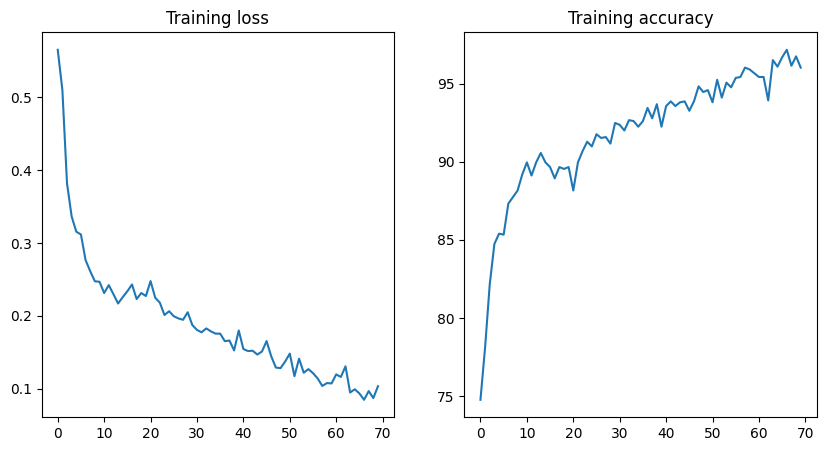

In [153]:
plot_results(loss_list3,accuracy_list3)

## Kfold Validation

In [156]:
input_size = 73
hidden_size = 64
num_layers = 4

acc_train_mean,acc_train_std,acc_test_mean,acc_test_std = Kfold_Validation(BiRNN_LSTM,
                     one_hot_dataset,True,input_size, hidden_size, num_layers,epochs=70)


In [ ]:
print(f'Train accuracy: {acc_train_mean} ± {acc_train_std}')
print(f'Test accuracy: {acc_test_mean} ± {acc_test_std}')

Train accuracy: 87.86057692307693 ± 4.004767291328213
Test accuracy: 87.40754437869823 ± 4.8290518918980085


----
### Part G)

In [165]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.5, random_state=42)


In [166]:
df_test.head()

,num,name,p_np,smiles,smiles length
1808,1812,doliracetam,1,C1=CC=CC2=C1C(C(N2CC(N)=O)=O)C3=CC=CC=C3,40
694,696,methamphetamine,1,CN[C@@H](C)Cc1ccccc1,20
906,908,quinacillin,0,CC1(C)S[C@@H]2[C@H](NC(=O)c3nc4ccccc4nc3C(O)=O...,66
544,546,GR94839_L,0,c1(CC(N2[C@H](CN(CC2)C(=O)C)C[N@]2CC[C@H](O)C2...,68
1847,1851,fluradoline,1,C1=C(F)C=CC3=C1C=C(SCCNC)C2=CC=CC=C2O3,38


In [167]:
from torch.utils.data import random_split

data_one_hot = make_one_hot(df_train['smiles'],vocab,75)
data_one_hot_test = make_one_hot(df_test['smiles'],vocab,75)

print("data (train) shape: ",data_one_hot.shape)
X_data = data_one_hot.reshape(data_one_hot.shape[0],-1)
X_data_test = data_one_hot_test.reshape(data_one_hot_test.shape[0],-1)

my_dataset = MyDataset(X_data,df_train['p_np'].values)
one_hot_dataset = MyDataset(data_one_hot,df_train['p_np'].values)

my_dataset_test = MyDataset(X_data_test,df_test['p_np'].values)
one_hot_dataset_test = MyDataset(data_one_hot_test,df_test['p_np'].values)

batch_size = 32
 #np.array(my_dataset)
train_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(my_dataset_test, batch_size=1, shuffle=False)

train_dataloader_lstm = DataLoader(one_hot_dataset, batch_size=batch_size, shuffle=True)
test_dataloader_lstm = DataLoader(one_hot_dataset_test, batch_size=1, shuffle=False)

data (train) shape:  (1025, 75, 73)


## Training Models

In [168]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

fc_model = FCNet(X_data.shape[-1]).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.001)
num_epochs = 20
loss_list = []
accuracy_list = []

for _ in range(num_epochs):
    fc_model.train()

    epoch_loss = 0.0
    accuracies = []

    for (data, targets) in train_dataloader:
        data = data.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = fc_model(data).squeeze(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(outputs.shape)
        predicted = torch.zeros(outputs.shape[0]).to(device)
        indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        correct = (predicted == targets).sum().item()

        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

    print(f'Loss: {epoch_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
    loss_list.append(epoch_loss)
    accuracy_list.append(100*accuracy)

<IPython.core.display.Javascript object>

Loss: 0.5432, Accuracy: 75.47%
Loss: 0.4723, Accuracy: 76.23%
Loss: 0.3963, Accuracy: 81.82%
Loss: 0.3656, Accuracy: 82.86%
Loss: 0.3406, Accuracy: 85.70%
Loss: 0.3183, Accuracy: 86.55%
Loss: 0.3019, Accuracy: 87.31%
Loss: 0.2886, Accuracy: 88.64%
Loss: 0.2714, Accuracy: 88.92%
Loss: 0.2675, Accuracy: 90.15%
Loss: 0.2535, Accuracy: 90.62%
Loss: 0.2630, Accuracy: 87.97%
Loss: 0.2409, Accuracy: 92.14%
Loss: 0.2242, Accuracy: 91.67%
Loss: 0.2381, Accuracy: 88.92%
Loss: 0.2144, Accuracy: 93.37%
Loss: 0.2041, Accuracy: 93.09%
Loss: 0.1979, Accuracy: 93.28%
Loss: 0.1929, Accuracy: 93.84%
Loss: 0.1882, Accuracy: 93.84%


In [169]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

input_size = 73
hidden_size = 64
num_layers = 4

LSTM_model = RNN_LSTM(input_size, hidden_size, num_layers).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.001)
num_epochs = 70
accuracy_list2 = []
loss_list2 = []

for epoch in range(num_epochs):
    LSTM_model.train()

    epoch_loss = 0.0
    accuracies = []

    for (data, targets) in train_dataloader_lstm:
        data = data.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = LSTM_model(data).squeeze(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(outputs.shape)
        predicted = torch.zeros(outputs.shape[0]).to(device)
        indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        correct = (predicted == targets).sum().item()
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
    loss_list2.append(epoch_loss)
    accuracy_list2.append(100*accuracy)



<IPython.core.display.Javascript object>

Epoch: 1, Loss: 0.5890, Accuracy: 75.00%
Epoch: 2, Loss: 0.5307, Accuracy: 77.94%
Epoch: 3, Loss: 0.4935, Accuracy: 77.56%
Epoch: 4, Loss: 0.4805, Accuracy: 74.81%
Epoch: 5, Loss: 0.4345, Accuracy: 77.56%
Epoch: 6, Loss: 0.4059, Accuracy: 75.47%
Epoch: 7, Loss: 0.3923, Accuracy: 82.10%
Epoch: 8, Loss: 0.3749, Accuracy: 85.23%
Epoch: 9, Loss: 0.4624, Accuracy: 82.67%
Epoch: 10, Loss: 0.5325, Accuracy: 76.89%
Epoch: 11, Loss: 0.5142, Accuracy: 78.03%
Epoch: 12, Loss: 0.4650, Accuracy: 77.84%
Epoch: 13, Loss: 0.4411, Accuracy: 78.79%
Epoch: 14, Loss: 0.4165, Accuracy: 82.48%
Epoch: 15, Loss: 0.3838, Accuracy: 82.86%
Epoch: 16, Loss: 0.3719, Accuracy: 82.77%
Epoch: 17, Loss: 0.3995, Accuracy: 79.73%
Epoch: 18, Loss: 0.4683, Accuracy: 78.69%
Epoch: 19, Loss: 0.3788, Accuracy: 82.67%
Epoch: 20, Loss: 0.3369, Accuracy: 84.75%
Epoch: 21, Loss: 0.3041, Accuracy: 86.65%
Epoch: 22, Loss: 0.3032, Accuracy: 86.36%
Epoch: 23, Loss: 0.3087, Accuracy: 85.70%
Epoch: 24, Loss: 0.2838, Accuracy: 87.69%
E

In [170]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

input_size = 73
hidden_size = 64
num_layers = 4

BILSTM_model = BiRNN_LSTM(input_size, hidden_size, num_layers).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(BILSTM_model.parameters(), lr=0.001)
num_epochs = 70
accuracy_list2 = []
loss_list2 = []

for epoch in range(num_epochs):
    BILSTM_model.train()

    epoch_loss = 0.0
    accuracies = []

    for (data, targets) in train_dataloader_lstm:
        data = data.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = BILSTM_model(data).squeeze(-1)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        # print(outputs.shape)
        predicted = torch.zeros(outputs.shape[0]).to(device)
        indices = (outputs > 0.5).nonzero(as_tuple=False).squeeze()
        predicted[indices] = 1

        correct = (predicted == targets).sum().item()
        accuracies.append(correct / targets.size(0))

    epoch_loss /= len(train_dataloader)
    accuracy = np.mean(accuracies)

    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {100*accuracy:.2f}%')
    loss_list2.append(epoch_loss)
    accuracy_list2.append(100*accuracy)



<IPython.core.display.Javascript object>

Epoch: 1, Loss: 0.5614, Accuracy: 76.61%
Epoch: 2, Loss: 0.5115, Accuracy: 77.94%
Epoch: 3, Loss: 0.3694, Accuracy: 84.56%
Epoch: 4, Loss: 0.3178, Accuracy: 86.74%
Epoch: 5, Loss: 0.3749, Accuracy: 84.75%
Epoch: 6, Loss: 0.5005, Accuracy: 80.11%
Epoch: 7, Loss: 0.4883, Accuracy: 79.17%
Epoch: 8, Loss: 0.3788, Accuracy: 84.85%
Epoch: 9, Loss: 0.3548, Accuracy: 83.24%
Epoch: 10, Loss: 0.2901, Accuracy: 87.12%
Epoch: 11, Loss: 0.3375, Accuracy: 85.61%
Epoch: 12, Loss: 0.2630, Accuracy: 88.54%
Epoch: 13, Loss: 0.2540, Accuracy: 88.26%
Epoch: 14, Loss: 0.2432, Accuracy: 89.30%
Epoch: 15, Loss: 0.2712, Accuracy: 87.88%
Epoch: 16, Loss: 0.2379, Accuracy: 87.59%
Epoch: 17, Loss: 0.2314, Accuracy: 88.73%
Epoch: 18, Loss: 0.2805, Accuracy: 86.36%
Epoch: 19, Loss: 0.2740, Accuracy: 88.16%
Epoch: 20, Loss: 0.2384, Accuracy: 89.39%
Epoch: 21, Loss: 0.2710, Accuracy: 86.74%
Epoch: 22, Loss: 0.2735, Accuracy: 86.84%
Epoch: 23, Loss: 0.2433, Accuracy: 89.02%
Epoch: 24, Loss: 0.2557, Accuracy: 86.46%
E

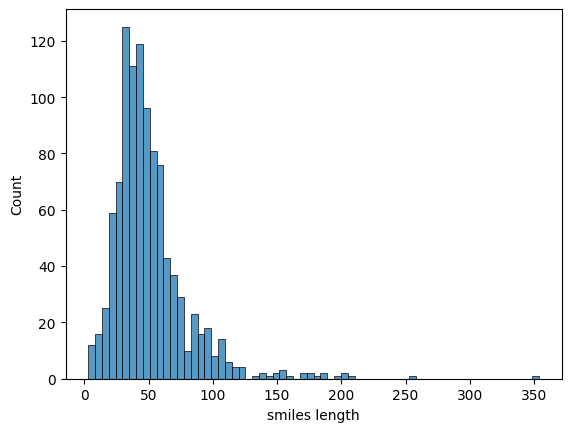

In [171]:
sns.histplot(df_test['smiles length']);

In [172]:
# FC
fc_res = []
lstm_res = []
bilstm_res = []


fc_model.eval()
with torch.no_grad():
  test_accuracy = 0
  for (data, targets) in test_dataloader:
      # print('ppp')
      data = data.to(device).float()
      targets = targets.to(device).float()
      test_outputs = fc_model(data)

      predicted = torch.zeros(test_outputs.shape[0]).to(device)
      indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
      predicted[indices] = 1

      x = (predicted == targets)
      fc_res.append(np.array(x[0].cpu()))


# LSTM
LSTM_model.eval()
with torch.no_grad():
  test_accuracy = 0
  for (data, targets) in test_dataloader_lstm:
      data = data.to(device).float()
      targets = targets.to(device).float()
      test_outputs = LSTM_model(data)

      predicted = torch.zeros(test_outputs.shape[0]).to(device)
      indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
      predicted[indices] = 1

      x = (predicted == targets)
      lstm_res.append(np.array(x[0].cpu()))

# BILSTM
BILSTM_model.eval()
with torch.no_grad():
  test_accuracy = 0
  for (data, targets) in test_dataloader_lstm:
      data = data.to(device).float()
      targets = targets.to(device).float()
      test_outputs = BILSTM_model(data)

      predicted = torch.zeros(test_outputs.shape[0]).to(device)
      indices = (test_outputs > 0.5).nonzero(as_tuple=False).squeeze()
      predicted[indices] = 1

      x = (predicted == targets)
      bilstm_res.append(np.array(x[0].cpu()))

In [173]:

# Create 10 bins with equal group sizes
bins = np.linspace(df_test['smiles length'].min(),df_test['smiles length'].max(), 10)

# Use digitize to bin the data
bin_indices = np.digitize(df_test['smiles length'].values, bins)

print(bin_indices)

[1 1 2 ... 1 2 1]


In [174]:
correct_fc = [0 for _ in range(10)]
correct_lstm = [0 for _ in range(10)]
correct_bilstm = [0 for _ in range(10)]
counts = [0 for _ in range(10)]

for index,i in enumerate(bin_indices):
  if fc_res[index]:
    correct_fc[i-1] += 1
  if lstm_res[index]:
    correct_lstm[i-1] += 1
  if bilstm_res[index]:
    correct_bilstm[i-1] += 1

  counts[i-1] += 1

In [175]:
fc_acc = []
lstm_acc = []
bilstm_acc = []

for i in range(10):
  if counts[i] > 0:
    fc_acc.append(correct_fc[i]/counts[i])
    lstm_acc.append(correct_lstm[i]/counts[i])
    bilstm_acc.append(correct_bilstm[i]/counts[i])

In [177]:
counts

[438, 469, 91, 13, 8, 4, 1, 0, 0, 1]

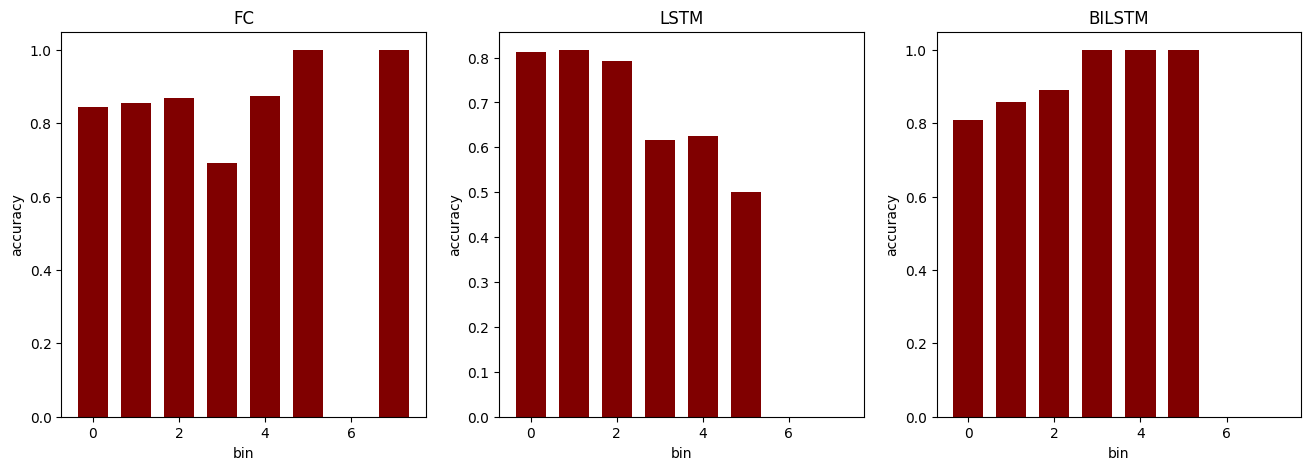

In [176]:
# Create subplots
plt.figure(figsize=(16, 5))

# First subplot
plt.subplot(1, 3, 1)  # (rows, columns, plot number)
plt.bar(range(len(fc_acc)), fc_acc, color ='maroon',
        width = 0.7)

plt.xlabel("bin")
plt.ylabel("accuracy")
plt.title("FC")

# Second subplot
plt.subplot(1, 3, 2)
plt.bar(range(len(fc_acc)), lstm_acc, color ='maroon',
        width = 0.7)
plt.xlabel("bin")
plt.ylabel("accuracy")
plt.title("LSTM")


# Second subplot
plt.subplot(1, 3, 3)
plt.bar(range(len(fc_acc)), bilstm_acc, color ='maroon',
        width = 0.7)
plt.xlabel("bin")
plt.ylabel("accuracy")
plt.title("BILSTM")

# Display the plots
plt.show()